# 15. Frame Selected Matching

In [1]:
from src import *

## Description

We look in this section for the capacity of matching individuals using frame selected gradients.

GOAL: Compute accuracy of frame selected gradients versus movie

## Table of Contents
- [Frame selected emotion gradients](#comparison)

<a class="anchor" id="comparison"></a>
## Frame selected (by emotion) gradients

In [2]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

Load frame selected and full movie gradients (individual level)

In [3]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/treshed_series.pkl')

# del fselect_series['Rest']
del total_series['Rest']

In [14]:
fselected_series = f_series[1][(45,95)]

In [15]:
# compute threshed picked timeseries of same length
f_selected_gradients = {k:{} for k in fselected_series}

for mname in fselected_series:
    tmp_dict = fselected_series[mname]
    
    for _id in tmp_dict:
        tmp_series = tmp_dict[_id]
        fc_selects = FC(tmp_series)
        g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
        g_selects.fit(fc_selects)
        f_selected_gradients[mname][_id] = g_selects.gradients_

In [16]:
# compute randomly picked timeseries of same length
np.random.seed(19)
full_movie_grads = {k:{} for k in fselected_series}

for mname in fselected_series:
    perc_left = fselected_series[mname]['S15'].shape[0]
    tmp_dict = total_series[mname]
    
    for _id in tmp_dict:
        tmp_series = tmp_dict[_id]
        tmp_index = np.random.choice(np.arange(len(tmp_series)), perc_left,replace=False)
        tmp_series = tmp_series[tmp_index]
        
        fc_selects = FC(tmp_series)
        g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
        g_selects.fit(fc_selects)
        full_movie_grads[mname][_id] = g_selects.gradients_

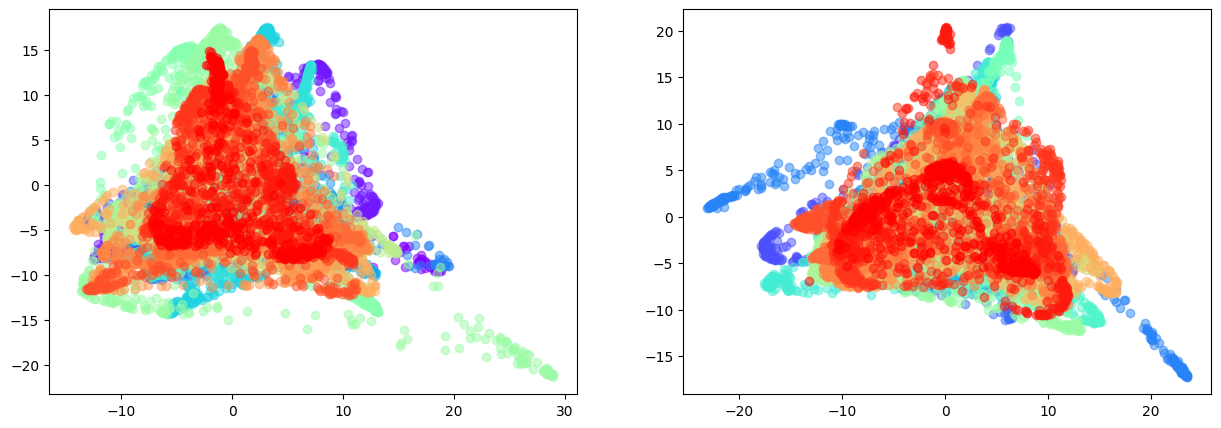

In [17]:
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 30))

fig,ax = plt.subplots(1,2,figsize=(15,5))
aligned,_,_ = procrustes_align(list(f_selected_gradients['Sintel'].values()))
for idx,_id in enumerate(f_selected_gradients['Sintel']):
    ax[0].scatter(aligned[idx][:,0],aligned[idx][:,1], color=color[idx], alpha=0.5)
    
aligned,_,_ = procrustes_align(list(f_selected_gradients['TearsOfSteel'].values()))
for idx,_id in enumerate(f_selected_gradients['TearsOfSteel']):
    ax[1].scatter(aligned[idx][:,0],aligned[idx][:,1], color=color[idx], alpha=0.5)

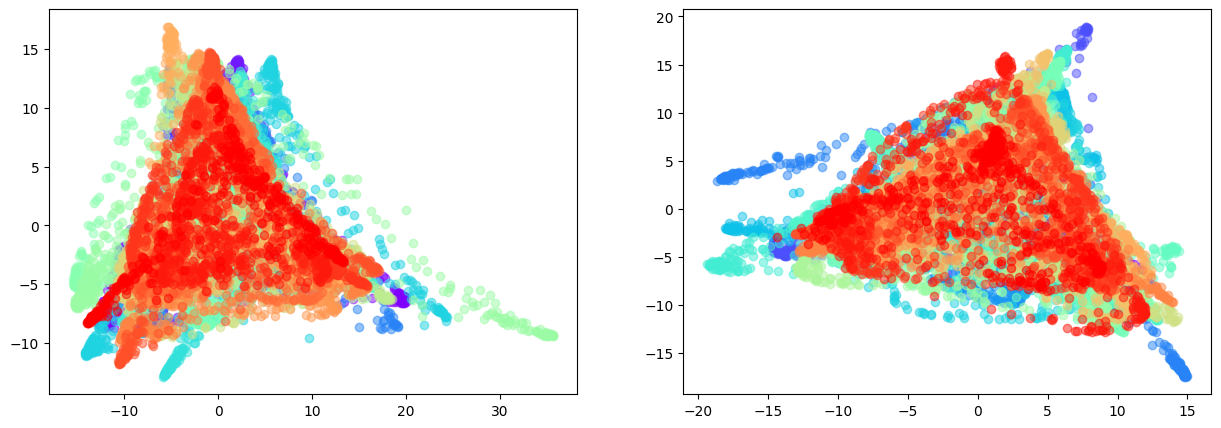

In [18]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
aligned,_,_ = procrustes_align(list(full_movie_grads['Sintel'].values()))
for idx,_id in enumerate(full_movie_grads['Sintel']):
    ax[0].scatter(aligned[idx][:,0],aligned[idx][:,1], color=color[idx], alpha=0.5)
    
aligned,_,_ = procrustes_align(list(full_movie_grads['TearsOfSteel'].values()))
for idx,_id in enumerate(full_movie_grads['TearsOfSteel']):
    ax[1].scatter(aligned[idx][:,0],aligned[idx][:,1], color=color[idx], alpha=0.5)

Compute accuracy grid

In [19]:
all_gradients = {}
for mname in f_selected_gradients:
    if 'Rest' in mname: continue
    all_gradients[mname+'_fselect'] = f_selected_gradients[mname]
for mname in full_movie_grads:
    all_gradients[mname] = full_movie_grads[mname]

In [ ]:
nbcol = len(f_selected_gradients) + len(full_movie_grads)
pred_grid = np.zeros((2,nbcol))

targets = [all_gradients['AfterTheRain_fselect'], all_gradients['AfterTheRain']]
for idxi, target in enumerate(targets):
    for idxj,j in enumerate(tqdm(all_gradients)):
        database = all_gradients[j]

        subjects = list(database.keys())
        database_grad = [database[sub] for sub in subjects]

        matches = []
        for sidx, sub in enumerate(subjects):
            target_grad = target[sub]
            distances = [gradients_distance2(database_grad[i], target_grad, pmethod="L2", similarity='spearman') 
                         for i in range(len(database_grad))]

            indexmatch = np.argsort(distances)[:1]
            bestmatch = [subjects[b] for b in indexmatch]
            matches.append(sub in bestmatch)
        pred_grid[idxi,idxj]   = np.mean(matches)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
labels = []
for k in list(all_gradients.keys()):
    if len(k.split('_')) == 1:
        labels.append(k[:3] + '_r')
    else:
        labels.append(k[:3] + '_f')
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(pred_grid[0], label='fselect')
ax.plot(pred_grid[1], label='random')
ax.set_xticks(np.arange(len(all_gradients)))
ax.set_xticklabels(labels)
ax.legend()

In [12]:
pred_grid[1][14:].mean()

0.43809523809523815

In [13]:
pred_grid[0][:14].mean()

0.3595238095238096

In [8]:
np.random.seed(99)

null_repetition = 1

nbcol = len(f_selected_gradients) + len(full_movie_grads)
pred_grid = np.zeros((nbcol, nbcol))
null_grid = np.zeros((null_repetition,nbcol, nbcol))

for idxk,k in enumerate(tqdm(all_gradients)):
    target   = all_gradients[k]
    for idxj,j in enumerate(all_gradients):
        database = all_gradients[j]

        subjects = list(database.keys())
        database_grad = [database[sub] for sub in subjects]

        matches = []
        null_matches = np.zeros((null_repetition, len(subjects)))
        for sidx, sub in enumerate(subjects):
            target_grad   = target[sub]

            # align all database gradients to target gradient
            aligned_grad,_,score = procrustes_align(database_grad, ref=target_grad)
#             if np.sum(np.asarray(score) > 100) > 0: print('Warning: might not be well-aligned') #the choice of 100 is arbitrary and empirically motivated
            
            distances = [gradients_distance2(aligned_grad[i], target_grad, pmethod="L2", similarity=True) 
                         for i in range(len(aligned_grad))]

            indexmatch = np.argsort(distances)[:1]
            bestmatch = [subjects[b] for b in indexmatch]

            for nbr in range(null_repetition):
                null_subjects = deepcopy(subjects)
                np.random.shuffle(null_subjects)
                nullmatch = [null_subjects[b] for b in indexmatch]
                null_matches[nbr, sidx] = sub in nullmatch

            matches.append(sub in bestmatch)

        null_grid[:,idxk,idxj] = np.mean(null_matches,axis=1)
        pred_grid[idxk,idxj]   = np.mean(matches)

  0%|          | 0/28 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'identifiability accuracy'}>

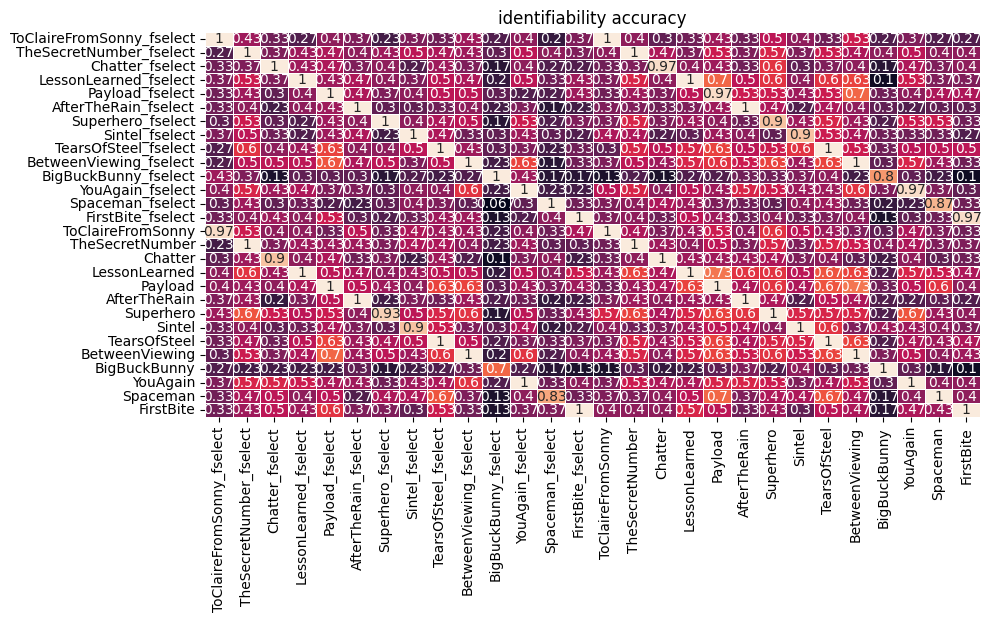

In [11]:
plt.figure(figsize=(10,5))
plt.title("identifiability accuracy")
x_axis_labels = list(all_gradients.keys())
sns.heatmap(pred_grid, linewidth=0.5,  annot=True, xticklabels=x_axis_labels, yticklabels=x_axis_labels, cbar=False)